In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("../src")

# Add autoreload magic command
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
from IPython.display import display

# from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from model_selection import modelSelection

warnings.simplefilter(action="ignore", category=FutureWarning)


file_path = "../data/carotenoid_training_data.csv"
df = pd.read_csv(file_path)
INPUT_VARS = df.columns[:-1]
INPUT_VARS = list(INPUT_VARS.values)
RESPONSE_VARS = [df.columns[-1]]

print(f"Input variables: {INPUT_VARS}" f"\nResponse variable: {RESPONSE_VARS}")
print(f"Shape of the dataframe: {df.shape}")


# Calculate bounds of proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(columns=input_vars)
    X = df[input_vars]
    for col in input_vars:
        MAX = X[col].max()
        MIN = X[col].min()
        DELTA = MAX - MIN
        lb = MIN - epsilon * DELTA
        ub = MAX + epsilon * DELTA
        if lb < 0:
            lb = 0
        bounds.loc["min", col] = lb
        bounds.loc["max", col] = ub
    return bounds


# Create train/test sets
df.sort_values(by="prod", ascending=False, inplace=True)
test = df[df['prod'] > 6].copy()
train = df[df['prod'] <= 6].copy()

X_train = train.drop("prod", axis=1)
y_train = train["prod"].values.ravel()

X_test = test.drop("prod", axis=1)
y_test = test["prod"].values.ravel()

bounds = get_bounds(train, INPUT_VARS)
display(bounds)

Input variables: ['ERG8', 'ERG10', 'ERG12', 'ERG13', 'ERG19', 'ERG20', 'IDI1', 'tHMG1']
Response variable: ['prod']
Shape of the dataframe: (168, 9)


,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1
min,0,0,0,0,0,0,0.084584,0
max,21.70044,21.762191,25.856475,23.314336,17.536062,22.215345,5.845552,12.536361


In [2]:
train.shape, test.shape

((132, 9), (36, 9))

# Model selection (NCV)

In [4]:
# Uncomment to run model selection
# modelSelection(X_train, y_train)

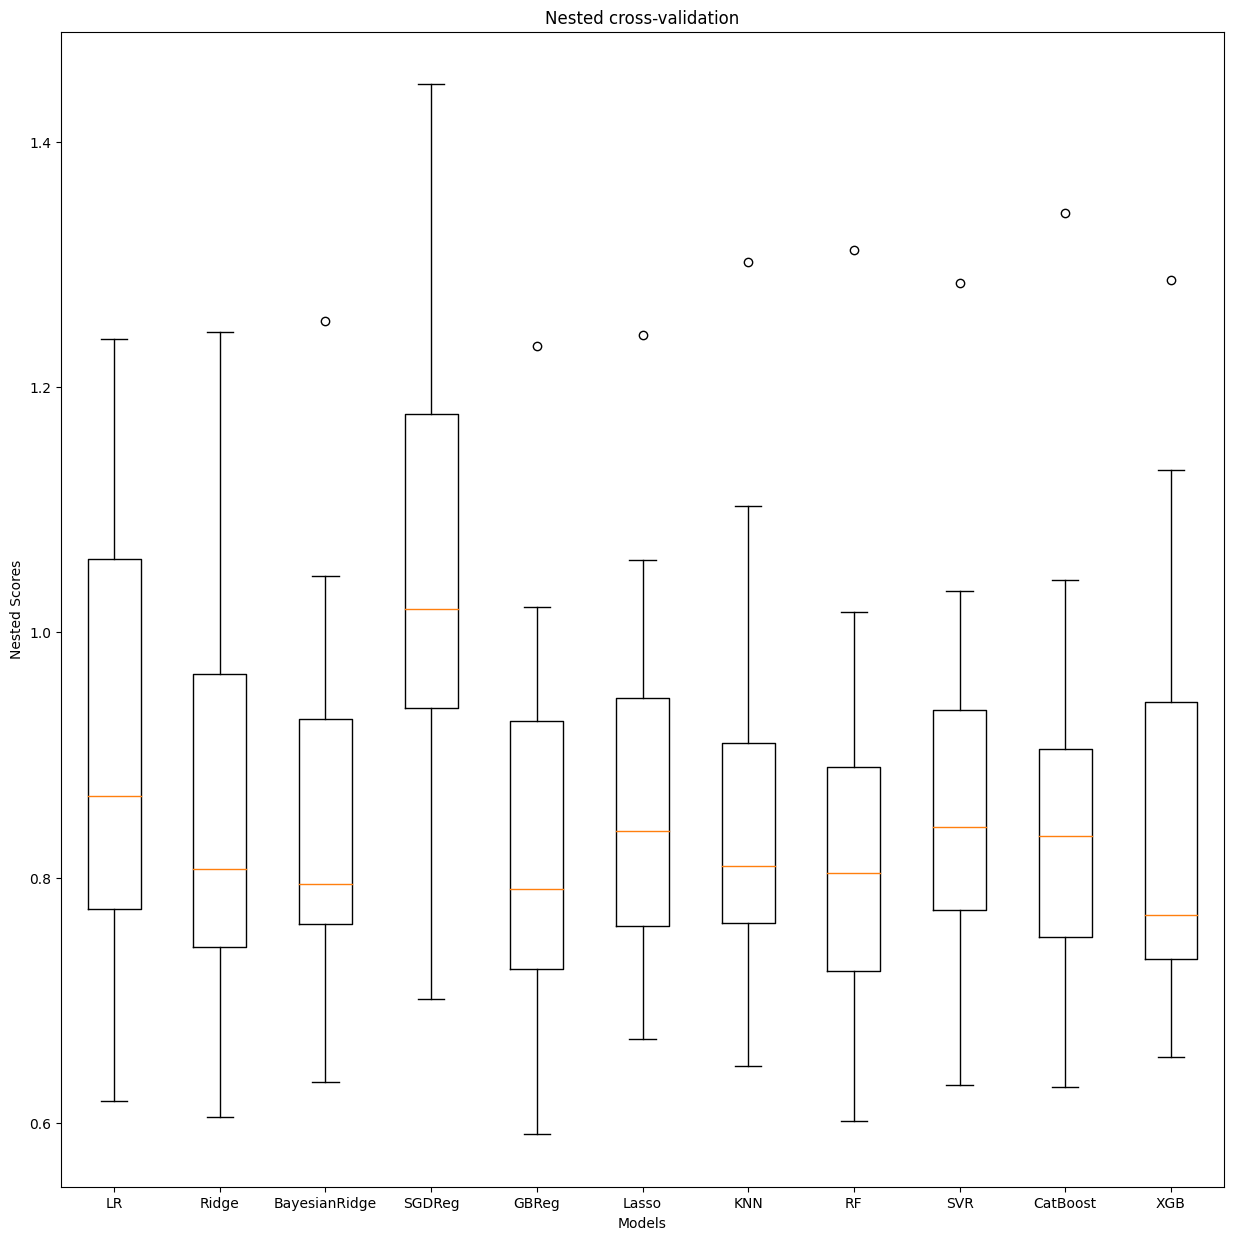


# ML training (Optuna)

In [5]:
# import optuna
# from sklearn.model_selection import cross_val_score
# import xgboost as xgb

# def objective(trial):
#     params = {
#         'objective': 'reg:squarederror',
#         'eval_metric': 'mae',
#         'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 3, 200),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 12)
#     }
    
#     model = xgb.XGBRegressor(**params)
    
#     # Perform cross-validation
#     scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
#     mae = -scores.mean()
    
#     return mae

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# final_model = xgb.XGBRegressor(**best_params)
# final_model.fit(X_train, y_train)

In [6]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

X_train = df[INPUT_VARS]
y_train = df[RESPONSE_VARS].values.ravel()

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', [2, 3, 5, 6, 8])
    }
    
    model = RandomForestRegressor(**params)
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae = -scores.mean()
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train)

[I 2024-02-16 14:14:52,631] A new study created in memory with name: no-name-7ca42119-f3e5-479f-8662-0f9657761a19
[I 2024-02-16 14:14:53,284] Trial 0 finished with value: 1.8765718819968282 and parameters: {'n_estimators': 99, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 8}. Best is trial 0 with value: 1.8765718819968282.
[I 2024-02-16 14:14:53,835] Trial 1 finished with value: 1.8544503824650078 and parameters: {'n_estimators': 101, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 3}. Best is trial 1 with value: 1.8544503824650078.
[I 2024-02-16 14:14:54,342] Trial 2 finished with value: 1.8635638974545627 and parameters: {'n_estimators': 88, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 6}. Best is trial 1 with value: 1.8544503824650078.
[I 2024-02-16 14:14:55,074] Trial 3 finished with value: 1.8630794990083455 and parameters: {'n_estimators': 136, 'max_depth': 4, 'min_samples_split': 9

RandomForestRegressor(max_depth=7, max_features=2, min_samples_split=6,
                      n_estimators=61)

# Model evaluation

In [7]:
def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values

mae_values = bootstrap(X_train, y_train, final_model)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
final_model.fit(X_train, y_train)

with open("../models/rf_carotenoid.pkl", "wb") as f:
    final_model.fit(X_train, y_train)
    pickle.dump(final_model, f)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


Bootstraped Mean(MAE) = 1.3763634818616044


# Explainable AI 

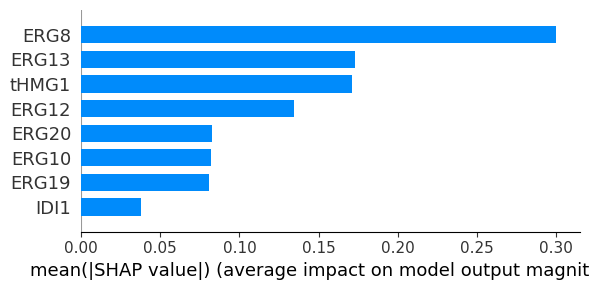

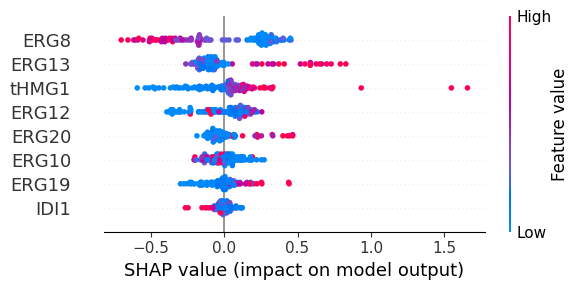

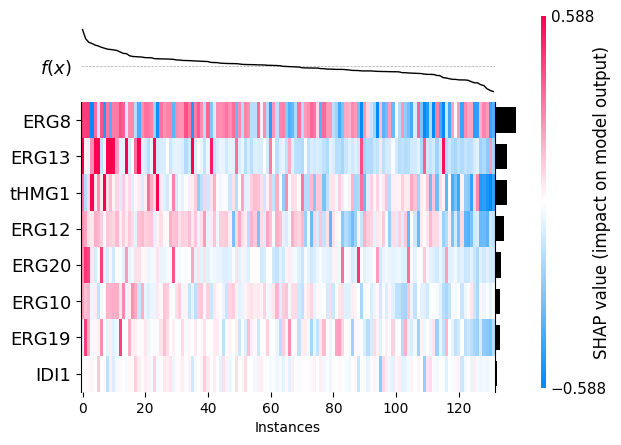

In [11]:
import shap
import matplotlib.pyplot as plt


def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


shap_explainer = shap.TreeExplainer(final_model, train[INPUT_VARS])
shap_values = shap_explainer(train[INPUT_VARS])
shap_df = pd.DataFrame(shap_values.values, columns=INPUT_VARS)
shap_df["pred"] = final_model.predict(train[INPUT_VARS])
shap_df["true"] = train[RESPONSE_VARS].values.ravel()
shap_df.sort_values(by="pred", ascending=False, inplace=True)
shap.summary_plot(shap_values, train[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, train[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

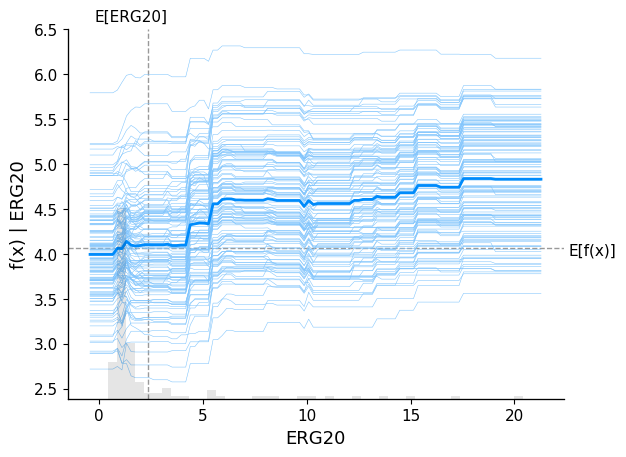

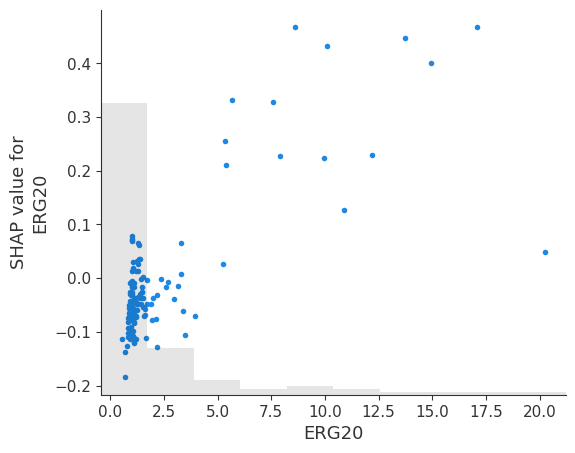

In [34]:
feature = "ERG20"
pdplot(train[INPUT_VARS], feature, final_model, ice=True)
shap_scatter(feature)

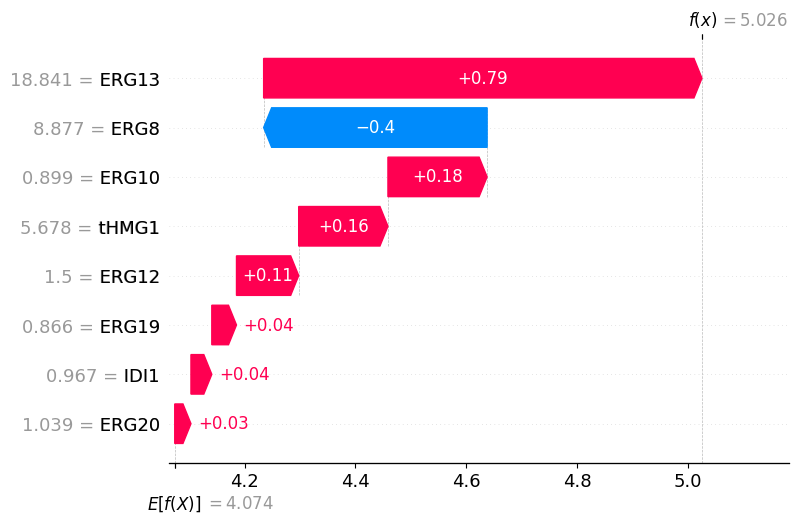

In [13]:
idx = 1
shap.plots.waterfall(shap_values[idx])

In [14]:
# Create synthetic dataset from bounds
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(1000)
LB = bounds.T["min"].values.tolist()
UB = bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["Caroternoi"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("Caroternoi", ascending=False, inplace=True)
# Drop rows with Caroternoi < 0
sample_df = sample_df[sample_df["Caroternoi"] > 0]
X_synth = sample_df[INPUT_VARS]
y_synth = sample_df["Caroternoi"]

Intercept 4.316851504560944
Prediction_local [6.74253051]
Right: 7.300842122010211


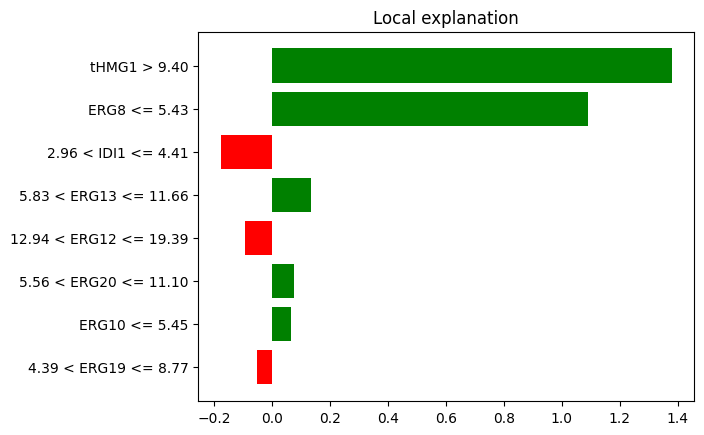

In [39]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_synth[INPUT_VARS].values, feature_names=X_synth[INPUT_VARS].columns.tolist(),  
                                                   verbose=True, mode='regression')
i = 4
exp = explainer.explain_instance(X_synth[INPUT_VARS].values[i], final_model.predict)
exp.show_in_notebook(show_table=True, show_all=True)
exp.as_list()
exp.as_pyplot_figure();

# Sampling

In [17]:
test.head(5)

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
159,8.055299,6.361974,2.989112,10.030468,2.530277,1.613322,1.603377,12.883930,10.563800
117,4.382417,1.525546,1.180070,1.533178,1.411179,1.349900,1.508734,19.775550,10.401666
155,7.336543,3.662594,7.673811,2.682688,2.195583,4.418530,1.014994,13.672108,9.522851
61,0.322517,1.081516,0.214028,11.495731,1.872004,1.773278,0.470616,2.945630,9.489132
95,5.334261,1.253070,1.394103,7.503345,1.007924,1.007683,1.242062,9.589966,9.269715


In [43]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["tHMG1"].loc["min"] = 9
sampling_bounds["tHMG1"].loc["max"] = bounds["tHMG1"].loc["max"]

sampling_bounds["ERG8"].loc["min"] = bounds['ERG8'].loc['min'] 
sampling_bounds["ERG8"].loc["max"] = 6 # bounds["ERG8"].loc["max"]

sampling_bounds["ERG10"].loc["min"] = bounds['ERG10'].loc['min'] 
sampling_bounds["ERG10"].loc["max"] = 6 # bounds['ERG10'].loc['min'] 

sampling_bounds["ERG12"].loc["min"] = 6 # bounds["ERG12"].loc["min"]
sampling_bounds["ERG12"].loc["max"] = 13

sampling_bounds["ERG13"].loc["min"] = 5
sampling_bounds["ERG13"].loc["max"] = 12 # bounds["ERG13"].loc['max']

sampling_bounds["ERG19"].loc["min"] = 13 # bounds["ERG19"].loc["min"]
sampling_bounds["ERG19"].loc["max"] = bounds['ERG19'].loc['max']

sampling_bounds["ERG20"].loc["min"] = bounds['ERG20'].loc['min']
sampling_bounds["ERG20"].loc["max"] = bounds['ERG20'].loc['max']

sampling_bounds["IDI1"].loc["min"] = bounds["IDI1"].loc["min"]
sampling_bounds["IDI1"].loc["max"] = 4



# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(1000)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,pred
236,3.200317,4.175317,7.196227,8.080826,14.919361,13.508436,1.621191,12.447718,8.050307
814,2.647583,3.796076,12.029922,5.906874,14.624283,19.717826,1.734729,12.458105,7.975486
234,1.479039,2.151337,9.309387,6.566318,13.513148,15.162472,1.739286,12.520375,7.967203
565,1.173192,3.697578,6.635130,8.395041,13.747047,8.606233,2.586062,12.391806,7.915115
819,0.585947,1.707787,12.441928,7.812419,15.947313,18.366381,1.783900,12.406738,7.906760
336,0.624760,2.972864,12.778814,8.773597,15.672529,16.115614,1.717010,12.286449,7.903416
4,5.220508,3.507015,6.757207,10.342121,15.406730,9.766349,2.210075,12.334872,7.898744
634,4.335361,3.299735,12.659855,5.728844,14.188582,18.267255,2.976716,12.318730,7.888047
526,0.778340,3.991860,11.493502,9.483408,17.421424,18.907551,2.490794,12.311341,7.875722
762,5.461761,3.595659,11.985430,9.048957,15.784248,6.781908,1.640578,12.514086,7.870649


# Counterfactuals (`DiCE`)

In [51]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = train.sort_values("prod", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:1]

d = dice_ml.Data(
    dataframe=train, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn", model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=10,
    desired_range=[8.5, 10],
    permitted_range=bounds_to_dict(sampling_bounds),
)

cf_df = e1.cf_examples_list[0].final_cfs_df
e1.visualize_as_dataframe(show_only_changes=True)
cf_df.sort_values("prod", ascending=False, inplace=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:32<?, ?it/s]


KeyboardInterrupt: 

In [45]:
cf_df.sort_values("prod", ascending=False, inplace=True)
cf_df.head()

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
0,0.191938,0.0,6.965153,7.565769,13.000000,0.0,3.420188,12.303285,7.422489
0,0.000000,0.0,6.000000,5.000000,13.000000,0.0,3.746780,12.431213,7.411957
0,0.000000,0.0,10.172672,5.000000,13.000000,0.0,3.746780,12.421992,7.308141
0,0.000000,0.0,6.000000,9.584230,13.744797,0.0,3.746780,12.431213,7.280728
0,0.000000,0.0,10.172672,9.584230,13.744797,0.0,3.746780,12.431213,7.149449


# PCA

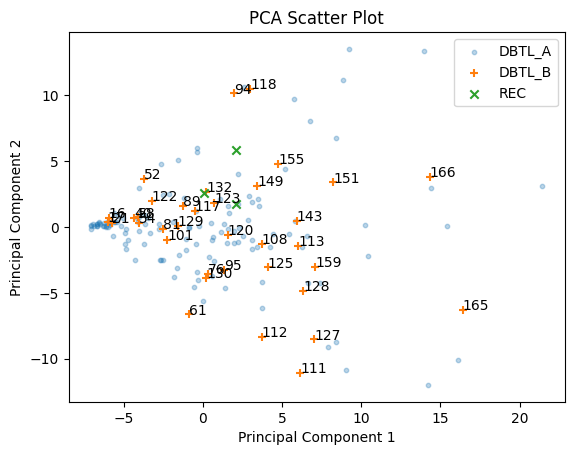

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

pca = PCA(n_components=2)
pca.fit(train[INPUT_VARS])
trans_df_A = pca.transform(train[INPUT_VARS])
trans_df_B = pca.transform(test[INPUT_VARS])
trans_rec = pca.transform(cf_df[INPUT_VARS].head(3)) 
# trans_rec = pca.transform(sample_df[INPUT_VARS].head(3))

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A", alpha=0.3, s=10)
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B", marker='+')
for i, txt in enumerate(test.index):
    plt.annotate(txt, (trans_df_B[i, 0], trans_df_B[i, 1]))
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC", marker='x')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()

# print(test[RESPONSE_VARS].sort_values(by='prod', ascending=False))

In [47]:
from scipy.spatial import distance

# Assuming you have two vectors vec1 and vec2
vec1 = cf_df.iloc[0][INPUT_VARS]
vec2 = test.iloc[2][INPUT_VARS]


def calculate_similarity(vec1, vec2):
    # Use the euclidean function from scipy's distance module to calculate the Euclidean distance
    euclidean_distance = distance.euclidean(vec1, vec2) 
    manhattan_distance = distance.cityblock(vec1, vec2)
    cosine_distance = distance.cosine(vec1, vec2)
    pearson_corr = np.corrcoef(vec1, vec2)[0][1]
    print(f"Euclidean distance: {euclidean_distance}")
    print(f'Manhattan distance: {manhattan_distance}')
    print(f'Cosine distance: {cosine_distance}')
    print(f'Pearson correlation: {pearson_corr}')

calculate_similarity(vec1, vec2)

Euclidean distance: 15.255298446555212
Manhattan distance: 35.395902152
Cosine distance: 0.2921151003790692
Pearson correlation: 0.2830309498186505
